# Centerline migration analysis

This code computes migration rates of the Seine river from centerlines in 1785 and XXXX. 

### author:
Martin LEMAY
martin.lemay@mines-paris.org

### Related publication

If you use this script, please refer to the following publication:
- Grimaud, J. L., Gouge, P., Huyghe, D., Petit, C., Lestel, L., Eschbach, D., Lemay, M., Catry, J., Quaisse, I., Imperor, A., Szewczyk, L., Mordant, D. Lateral river erosion impacts the preservation of Neolithic enclosures in alluvial plains. Sci Rep 13, 16566 (2023). https://doi.org/10.1038/s41598-023-43849-6

*WARNING: results may slightly differ from the related paper because of subsequent modifications of the code.*

### Dependencies
- numpy
- scipy
- matplotlib
- seaborn
- pandas
- shapely
- dtw-python

#### Python modules import

In [1]:
import os
import sys

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()

import dtw

parent_dir_path = os.path.dirname(os.getcwd())
package_path = os.path.join(parent_dir_path, "src")
if package_path not in sys.path:
    sys.path.append(package_path)
    
import pybend.algorithms.centerline_process_function as cpf
import pybend.algorithms.plot_functions as plot
import pybend.algorithms.pybend_io as io
from pybend.model.CenterlineCollection import CenterlineCollection

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



#### Input parameters

In [2]:
root = os.getcwd()
filename = "SeineRiverCenterlines.csv"

# Parameters:
width = 80. # channel width
depth_max = 2. # channel max depth

spacing = 20. # spacing [m] between channel point
smooth_distance = 1.5*width # channel point location smoothing distance
sinuo_thres = 1.05 # threshold for bends
n = 2. # exponent of curvature distribution function
curvature_filter_window = 10 # curvature filtering window
use_fix_nb_points = False
                
dmax = 0.7*width # maximal distance between 2 consecutive centroid at iterations n and n+1
smooth_trajec_window = 2
recompute_apex = False #5 # number of points per bend to recompute apex location to get consistency between bends
apex_proba_ponds=(2.,1.,1.) # curvature, amplitude, length

bend_evol_validity = 2 # minimum number of bends in a bendEvolution

# channel point tracking parameters
dmax = 3. * width # max allowed distance between points at centerlines t and t+1
distance_weight = 1.0 # weight on the distance between points at centerlines t and t+1
vel_perturb_weight = 0. # weight on the velocity perturbation
curvature_weight = 0.0 # weight on the curvature difference between pointsat centerlines t and t+1

### Import data, create centerline collections and apply dtw to track channel points

In [3]:
# create the centerline collection object from CenterlineProps file
map_dataset = io.load_centerline_collection_dataset_from_Flumy_csv(
            root + "/data/" + filename, sep=";"
        )
cl_collec = CenterlineCollection(
                map_dataset, spacing, smooth_distance,
                use_fix_nb_points, curvature_filter_window, 
                sinuo_thres=sinuo_thres, n=n,
                compute_curvature=True, interpol_props=True, find_bends=True)

cl_collec.match_centerlines(dmax = dmax, distance_weight=distance_weight,
                            vel_perturb_weight=vel_perturb_weight,
                            curvature_weight=curvature_weight,
                            window = 5, pattern="asymmetric")
print("Centerlines imported and matched")

2025-03-11 17:36:40,178 - pyBenD - INFO - Initialize Centerline object 1785
2025-03-11 17:36:40,179 - pyBenD - INFO - Resample points of centerline 1785
2025-03-11 17:36:40,180 - pyBenD - INFO - Smooth centerline 1785 path
2025-03-11 17:36:40,360 - pyBenD - INFO - Interpolate properties to new points (centerline 1785)
2025-03-11 17:36:42,234 - pyBenD - INFO - Compute channel point curvature (centerline 1785)
2025-03-11 17:36:42,378 - pyBenD - INFO - Centerline object 1785 initialized
2025-03-11 17:36:42,378 - pyBenD - INFO - Find bends
2025-03-11 17:36:42,384 - pyBenD - INFO - Bends found
2025-03-11 17:36:42,384 - pyBenD - INFO - Initialize Centerline object 1839
2025-03-11 17:36:42,385 - pyBenD - INFO - Resample points of centerline 1839
2025-03-11 17:36:42,386 - pyBenD - INFO - Smooth centerline 1839 path
2025-03-11 17:36:42,551 - pyBenD - INFO - Interpolate properties to new points (centerline 1839)
2025-03-11 17:36:44,541 - pyBenD - INFO - Compute channel point curvature (centerlin

Centerlines imported and matched


### Plot centerlines

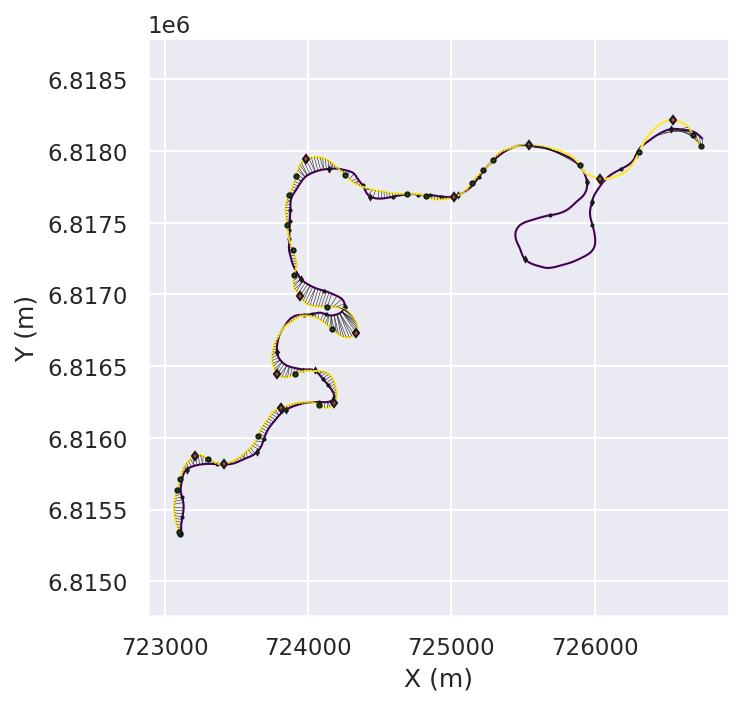

In [4]:
domain = [[],[]] # window range
plot.plot_centerline_collection("", cl_collec, domain, nb_cl=10, show = True,
                                annotate = False, plot_apex = True, plot_inflex = True,
                                plot_middle = False, plot_centroid = False, annot_text_size=10,
                                color_bend = False, plot_apex_trajec = True,
                                plot_centroid_trajec = False, plot_section = False, cmap_name="viridis",
                                plot_warping = True)

### Compute channel point migration

Number of points: 352
Average migration distance: 46.75 m
Median migration distance: 31.24 m


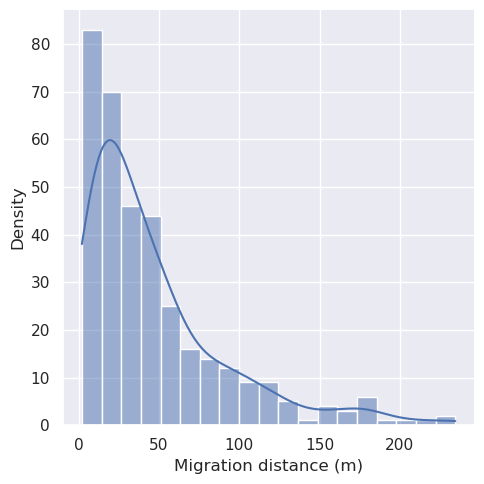

In [5]:
for i, key2 in enumerate(cl_collec.get_all_ages()[:-1]):
  key1 = cl_collec.get_all_ages()[i+1]

  ctls1 = cl_collec.centerlines[key1]
  ctls2 = cl_collec.centerlines[key2]

  distance = []
  for index1, index2 in enumerate(ctls1.index_cl_pts_prev_centerline):
    if (index1 < 0) or (index2 < 0):
      continue

    pt1 = ctls1.cl_points[int(index1)].pt
    pt2 = ctls2.cl_points[int(index2)].pt

    # migration distance
    distance += [cpf.distance(pt1, pt2)]

# Print results
print("Number of points: %s"%(len(distance)))
print("Average migration distance: %.2f m"%(np.mean(distance)))
print("Median migration distance: %.2f m"%(np.median(distance)))

# plot histograms of migration distance
sns.displot(distance, kind="hist", kde=True)
plt.xlabel("Migration distance (m)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()
